# Goodness of Fit Measures

Let's try this

In [173]:
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

import numpy as np
import scipy.io

import jax
# Important to enable 64-bit precision
jax.config.update("jax_enable_x64", True)

import jax.numpy as jnp
from jax import random
import tensorflow_probability.substrates.jax as tfp

from tinygp import GaussianProcess, kernels
from jaxns.utils import resample

import stingray
from stingray import Lightcurve, Powerspectrum
from stingray.modeling.gpmodeling import get_kernel, get_mean
from stingray.modeling.gpmodeling import get_prior, get_log_likelihood, get_gp_params

# suppress warnings
import warnings
warnings.filterwarnings("ignore")

# abbreviations for tensorflow distributions + bijectors
tfpd = tfp.distributions
tfpb = tfp.bijectors


In [174]:
datadir = "/Users/daniela/work/data/grb230307A/"
data = scipy.io.readsav(datadir+"acs_lc_bary.sav")
barytime = np.array(data["barytime"], dtype=float)
counts = np.array(data["counts"], dtype=float)
mean_bkg = np.mean(counts[-100:])
lc = Lightcurve(barytime, counts-mean_bkg)
minind = lc.time.searchsorted(0.0)
maxind = lc.time.searchsorted(60.0)
lc = lc.truncate(start=minind, stop=maxind, method="index")
ps = Powerspectrum(lc, norm="leahy")

INFO[2023-10-26 14:46:04,638]: Checking if light curve is well behaved. This can take time, so if you are sure it is already sorted, specify skip_checks=True at light curve creation.
INFO[2023-10-26 14:46:04,643]: Checking if light curve is sorted.
INFO[2023-10-26 14:46:04,645]: Computing the bin time ``dt``. This can take time. If you know the bin time, please specify it at light curve creation


<IPython.core.display.Javascript object>


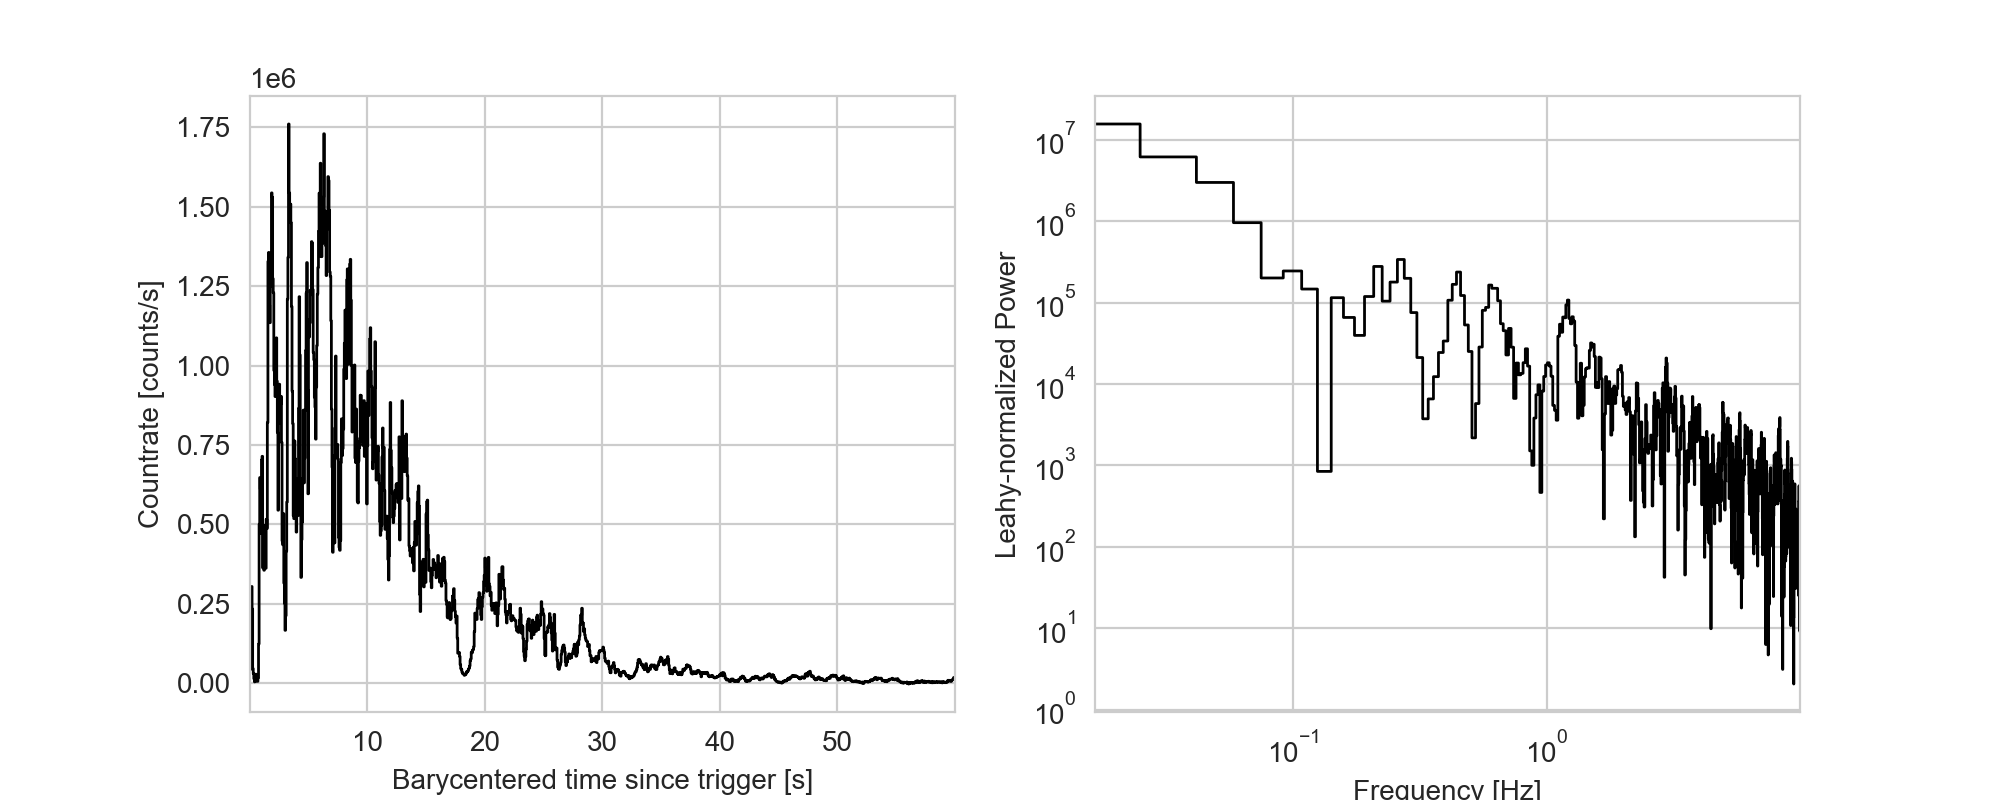

Text(0, 0.5, 'Leahy-normalized Power')

In [175]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

ax1.plot(lc.time, lc.countrate, lw=1, color="black", ds="steps-mid")
ax1.set_xlim(lc.time[0], lc.time[-1])
ax1.set_xlabel("Barycentered time since trigger [s]")
ax1.set_ylabel("Countrate [counts/s]")

ax2.loglog(ps.freq, ps.power, ds="steps-mid", lw=1, color="black")
ax2.set_xlim(ps.freq[0], ps.freq[-1])
ax2.set_xlabel("Frequency [Hz]")
ax2.set_ylabel("Leahy-normalized Power")

In [176]:
import pickle

In [177]:
with open(datadir+"intregal_drw_res.pkl", "rb") as f:
    res_rn = pickle.load(f)

In [178]:
with open(datadir+"intregal_drw_qpo_res.pkl", "rb") as f:
    res_qporn = pickle.load(f)

## Resampling the posterior

In [179]:
def resample_posterior(res, rkey):
    """
    Resample Nested Sampling posterior sample 
    based on the weights to provide unbiased
    posterior samples.

    Parameters
    ----------
    res : jaxns.Results object
        The object with the posterior results of 
        the Nested Sampling run

    rkey : jax.RandomState key
        A random key for reproducibility

    Returns
    -------
    samples_resampled : dict
        A dictionary with the resampled samples
    """
    log_p = res.log_dp_mean #log-prob

    # array for resampled samples
    samples_resampled = {}

    # go through samples, resample with weights to get 
    # a weighted posterior sample
    for name in res.samples.keys():
        samples = res.samples[name]

        weights = jnp.where(jnp.isfinite(samples), jnp.exp(log_p), 0.0)
        log_weights = jnp.where(jnp.isfinite(samples), log_p, -jnp.inf)
        sr = resample(
            rkey, samples, log_weights, S=max(10, int(res.ESS)), replace=True
    )
        samples_resampled[name] = sr

    return samples_resampled

In [180]:
samples_drw = resample_posterior(res_rn, random.PRNGKey(1342))
samples_qpo = resample_posterior(res_qporn, random.PRNGKey(1343))

In [181]:
def get_max_posterior_parameters(res):
    """
    Returns the optimal parameters for the model based on the NUTS sampling
    """
    max_post_idx = jnp.argmax(res.log_posterior_density)
    map_points = jax.tree_map(lambda x: x[max_post_idx], res.samples)

    return map_points


In [182]:
#idx = 0 

kernel_type_drw = "RN"
kernel_type_qpo = "QPO_plus_RN"

mean_type = "skew_gaussian"

params_list_drw = get_gp_params(kernel_type= kernel_type_drw, mean_type = mean_type)
params_list_qpo = get_gp_params(kernel_type= kernel_type_qpo, mean_type = mean_type)

#pars_log_drw = dict((k, samples_drw[k][idx]) for k in params_list_drw)
#pars_log_qpo = dict((k, samples_qpo[k][idx]) for k in params_list_qpo)

pars_log_drw = get_max_posterior_parameters(res_rn)
pars_log_qpo = get_max_posterior_parameters(res_qporn)

pars_drw = {}
for params in params_list_drw:
    if params[0:4] == "log_":
        pars_drw[params[4:]] = jnp.exp(pars_log_drw[params])
    else:
        pars_drw[params] = pars_log_drw[params]

pars_qpo = {}
for params in params_list_qpo:
    if params[0:4] == "log_":
        pars_qpo[params[4:]] = jnp.exp(pars_log_qpo[params])
    else:
        pars_qpo[params] = pars_log_qpo[params]

mean_drw = get_mean(mean_type=mean_type, mean_params=pars_drw)
mean_qpo = get_mean(mean_type=mean_type, mean_params=pars_qpo)

kernel_drw = get_kernel(kernel_type=kernel_type_drw, kernel_params=pars_drw)
kernel_qpo = get_kernel(kernel_type=kernel_type_qpo, kernel_params=pars_qpo)

gp_drw = GaussianProcess(kernel_drw, lc.time, mean_value=mean_drw(lc.time), diag=np.sqrt(np.abs(lc.counts)))
gp_qpo = GaussianProcess(kernel_qpo, lc.time, mean_value=mean_qpo(lc.time), diag=np.sqrt(np.abs(lc.counts)))

_, cond_drw = gp_drw.condition(lc.counts, lc.time)
_, cond_qpo = gp_qpo.condition(lc.counts, lc.time)

tgrid = np.linspace(lc.time[0], lc.time[-1], 1)

tgrid = lc.time #np.hstack([lc.time, tgrid])
#tgrid = np.sort(tgrid)

_, cond_drw_big = gp_drw.condition(lc.counts, tgrid)
_, cond_qpo_big = gp_qpo.condition(lc.counts, tgrid)

mu_drw_big = cond_drw_big.loc + mean_drw(tgrid)
mu_qpo_big = cond_qpo_big.loc + mean_qpo(tgrid)

std_drw_big = np.sqrt(cond_drw_big.variance)
std_qpo_big = np.sqrt(cond_qpo_big.variance)


In [183]:
tgrid_idx = []

for t in lc.time:
    idx = tgrid.searchsorted(t)
    tgrid_idx.append(idx)
    
tgrid_idx = jnp.array(tgrid_idx)

In [184]:

mu_drw = mu_drw_big[tgrid_idx]
mu_qpo = mu_qpo_big[tgrid_idx]
std_drw = std_drw_big[tgrid_idx]
std_qpo = std_qpo_big[tgrid_idx]

<IPython.core.display.Javascript object>


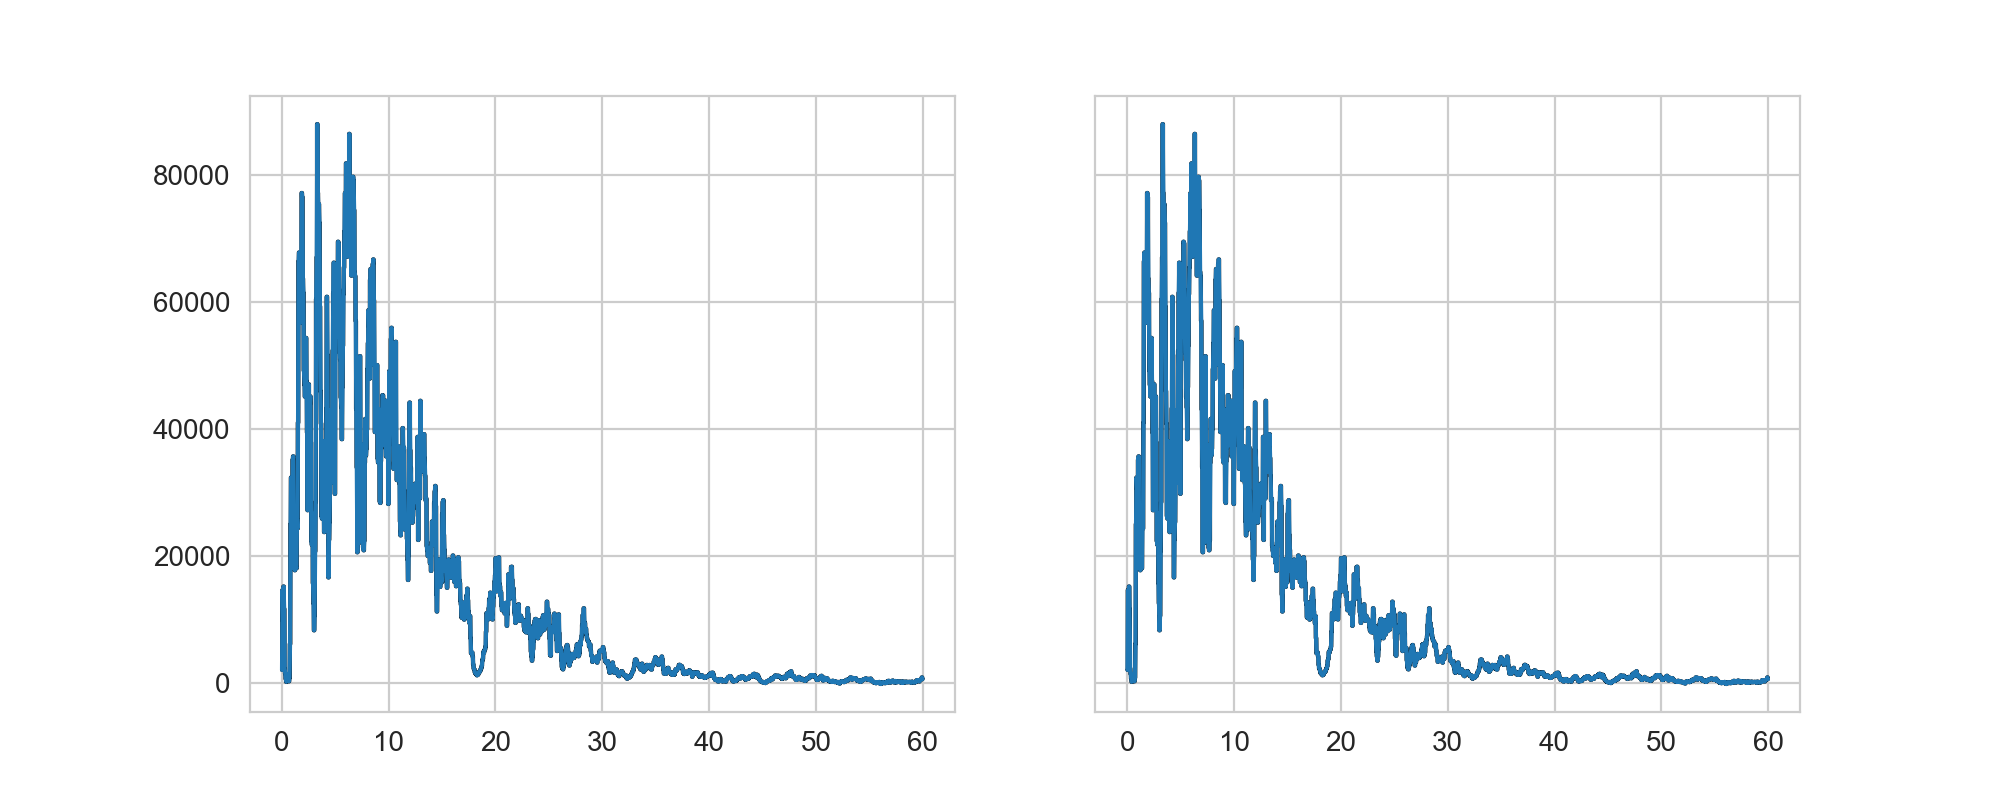

In [185]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4), sharex=True, sharey=True)

ax1.plot(lc.time, lc.counts, ds="steps-mid", color="black")
ax1.plot(tgrid, mu_drw_big, color=sns.color_palette()[0])
ax1.fill_between(tgrid, mu_drw_big + std_drw_big, mu_drw_big - std_drw_big, color=sns.color_palette()[0], alpha=0.3)


ax2.plot(lc.time, lc.counts, ds="steps-mid", color="black")
ax2.plot(tgrid, mu_qpo_big, color=sns.color_palette()[0])
ax2.fill_between(tgrid, mu_qpo_big + std_qpo_big, mu_qpo_big - std_qpo_big, color=sns.color_palette()[0], alpha=0.3)


In [188]:
mse_drw = np.sum((lc.counts - mu_drw)**2./np.sqrt(np.abs(lc.counts)))
mse_qpo = np.sum((lc.counts - mu_qpo)**2./np.sqrt(np.abs(lc.counts)))
print(f"MSE for DRW: {mse_drw}")
print(f"MSE for QPO+DRW: {mse_qpo}")

MSE for DRW: 0.024109424802661046
MSE for QPO+DRW: 0.02701062558682955


### Fraction of Unexplained Variance

Let's calculate the fraction of unexplained variance (FUV):

In [189]:
print(f"FUV DRW: {1.0 - np.sum((lc.counts - mu_drw)**2.)/np.var(lc.counts)}")
print(f"FUV QPO+DRW: {1. - np.sum((lc.counts - mu_qpo)**2.)/np.var(lc.counts)}")

FUV DRW: 0.9999999846758121
FUV QPO+DRW: 0.9999999828544747


Okay, that seems to be working and confirmed. Let's to some cross-validation, where we condition on a subset of the data points, and then predict on the rest of them.

In [190]:
def build_gp(pars_log, kernel_type, time, err, mean_type="skew_gaussian"):
    """
    Construct a GP based on the parameters in `pars_log` and for the given 
    kernel, time stamps and uncertainties.
    
    Parameters
    ----------
    pars_log : dict
        A dictionary with parameters
        
    kernel_type : str
        The type of kernel to use
        
    time, err : np.ndarray
        Arrays with time stamps and uncertainties to use in the GP
        
    mean_type : str, default "skew_gaussian"
        The type of mean function to use
    """
    
    params_list = get_gp_params(kernel_type= kernel_type, mean_type = mean_type)

    pars = {}
    
    for params in params_list:
        if params[0:4] == "log_":
            pars[params[4:]] = jnp.exp(pars_log[params])
        else:
            pars[params] = pars_log[params]
    
    mean = get_mean(mean_type=mean_type, mean_params=pars)
    kernel = get_kernel(kernel_type=kernel_type, kernel_params=pars)

    gp = GaussianProcess(kernel, time, mean_value=mean(time), diag=err)

    return gp, mean, kernel

def kfold_cv(pars_log, kernel_type, lc, folds=10, mean_type="skew_gaussian"):
    """
    K-fold cross validation of the R^2 score for the DRW or the 
    QPO model for the Gaussian Process
    
    Parameters
    ----------
    folds : int, default 10
        The number of folds in the crossvalidation
        
    pars_log : dict
        A dictionary with model parameters
        
    lc : stingray.Lightcurve object
        The light curve to condition on
        
    Returns
    -------
    cv_results : dict
        The dictionary with results from the cross-validatio 
    """
    npoints = int(len(lc.time)/folds)
    shuffled_idx = np.random.choice(np.arange(0, len(lc.time), 1, dtype=int), size=len(lc.time), replace=False)

    mu_test_all = []
    std_test_all  = []

    diff_all = []

    r2_all = []
    

    for k in range(folds):
        
        test_idx = shuffled_idx[k*npoints:(k+1)*npoints]
        train_idx1 = shuffled_idx[:k*npoints]
        train_idx2 = shuffled_idx[(k+1)*npoints:]

        train_idx = np.hstack([train_idx1, train_idx2])
        train_idx = np.sort(train_idx)

        gp, mean, _ = build_gp(pars_log, kernel_type, 
                          lc.time[train_idx], 
                          np.sqrt(np.abs(lc.counts[train_idx])))
        

        tgrid = lc.time[test_idx] 

        _, cond_test = gp.condition(lc.counts[train_idx], tgrid)

        mu_test = cond_test.loc + mean(tgrid)

        mu_test_all.append(mu_test)

        diff = np.abs(lc.counts[test_idx]-mu_test)
        diff_all.append(diff)

        r2 = np.sum(diff**2.) / (np.var(lc.counts[test_idx])*npoints)
        r2_all.append(r2)

        std_test = np.sqrt(cond_test.variance)
        std_test_all.append(std_test)
        
    cv_dict = {"mu": mu_test_all,
               "diff": diff_all,
               "r2": r2_all,
               "std": std_test_all}
    
    return cv_dict


Let's try it:

In [192]:
cv_rn = kfold_cv(pars_log_drw, "RN", lc, folds=5)
cv_qpo = kfold_cv(pars_log_qpo, "QPO_plus_RN", lc, folds=5)

In [193]:
np.mean(cv_rn["r2"])

0.030027430291113117

In [194]:
np.mean(cv_qpo["r2"])

0.027637284324419826

Fraction of unexplained variance based on cross-validation:

In [195]:
fuv_drw = 1.0 - np.mean(r2_drw_all)
fuv_qpo = 1.0 - np.mean(r2_qpo_all)

In [196]:
print(f"FUV, DRW = {fuv_drw} +/- {np.std(r2_drw_all)}")
print(f"FUV, DRW+QPO = {fuv_qpo} +/- {np.std(r2_qpo_all)}")

FUV, DRW = 0.9767156852839759 +/- 0.006358480569837953
FUV, DRW+QPO = 0.9807876596526549 +/- 0.006965308228891763


So the DRW and QPO models can both explain most of the variance for the Maximum A Posteriori example.

### Drawing from the Posterior

Maybe I should be doing this across different posterior samples? Get a distribution of FUV values?

In [197]:
nsamples = np.min([len(samples_drw[list(samples_drw.keys())[0]]),
                   len(samples_drw[list(samples_qpo.keys())[0]])])

In [198]:
nsamples

4546

In [203]:
nsim = 200
nfolds = 5

idx_all = np.random.choice(np.arange(0, nsamples, 1, dtype=int), size=nsim, replace=False)


kernel_type_drw = "RN"
kernel_type_qpo = "QPO_plus_RN"

mean_type = "skew_gaussian"

params_list_drw = get_gp_params(kernel_type= kernel_type_drw, mean_type = mean_type)
params_list_qpo = get_gp_params(kernel_type= kernel_type_qpo, mean_type = mean_type)

cv_rn_all = []
cv_qpo_all = []

r2_rn_all = []
r2_qpo_all = []

for i,idx in enumerate(idx_all):
    print(i)
    pars_log_drw = dict((k, samples_drw[k][idx]) for k in params_list_drw)
    pars_log_qpo = dict((k, samples_qpo[k][idx]) for k in params_list_qpo)

    cv_rn = kfold_cv(pars_log_drw, "RN", lc, folds=nfolds)
    cv_qpo = kfold_cv(pars_log_qpo, "QPO_plus_RN", lc, folds=nfolds)
    
    cv_rn_all.append(cv_rn)
    cv_qpo_all.append(cv_qpo)
    
    r2_rn_all.append(cv_rn["r2"])
    r2_qpo_all.append(cv_qpo["r2"])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


In [204]:
r2_rn_all = np.array(r2_rn_all)
r2_qpo_all = np.array(r2_qpo_all)

In [205]:
len(r2_rn_all)

200

In [206]:
np.savetxt(f"{datadir}integral_drw_r2_rn.dat", r2_rn_all)
np.savetxt(f"{datadir}integral_drw_r2_qpo.dat", r2_qpo_all)

In [211]:
print(np.mean(r2_rn_all))
print(np.mean(r2_qpo_all))


0.02817454658904029
0.028102223233561964


<IPython.core.display.Javascript object>


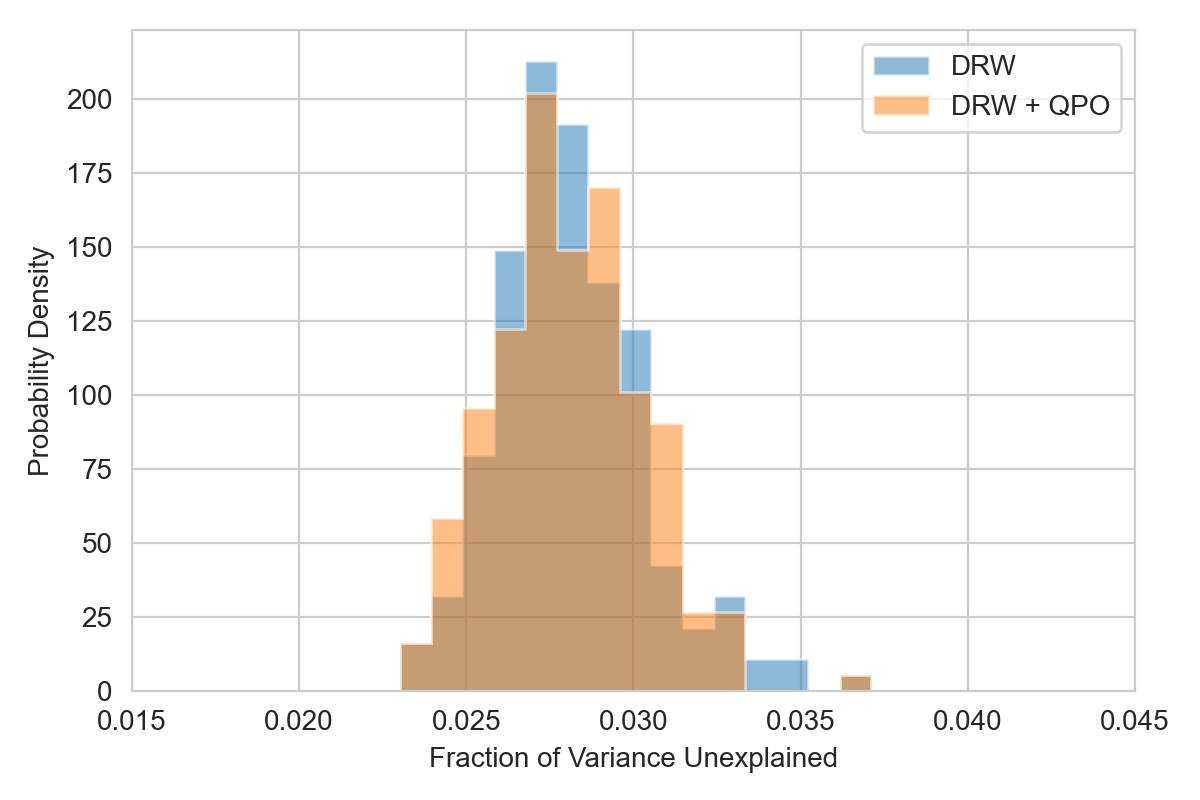

In [210]:
histrange = [np.min(np.hstack([r2_rn_all, r2_qpo_all])), np.max(np.hstack([r2_rn_all, r2_qpo_all]))]

nbins = 80

fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.hist(np.mean(r2_rn_all, axis=1), histtype="stepfilled", bins=nbins,
        alpha=0.5, range=histrange, label="DRW", density=True)
ax.hist(np.mean(r2_qpo_all, axis=1), histtype="stepfilled", bins=nbins,
        alpha=0.5, range=histrange, label="DRW + QPO", density=True)
ax.set_xlim(0.015, 0.045)

ax.legend()
ax.set_xlabel("Fraction of Variance Unexplained")
ax.set_ylabel("Probability Density")

fig.tight_layout()
#fig.savefig(f"{figdir}integral_fuv.pdf", format="pdf")

## Fermi Na I data: Goodness of Fit

INFO[2023-10-27 08:48:39,827]: make_lightcurve: tseg: 144.99889838695526
INFO[2023-10-27 08:48:39,828]: make_lightcurve: timebin:  2899
INFO[2023-10-27 08:48:39,878]: Checking if light curve is well behaved. This can take time, so if you are sure it is already sorted, specify skip_checks=True at light curve creation.
INFO[2023-10-27 08:48:39,879]: Checking if light curve is sorted.
INFO[2023-10-27 08:48:39,880]: Computing the bin time ``dt``. This can take time. If you know the bin time, please specify it at light curve creation


<IPython.core.display.Javascript object>


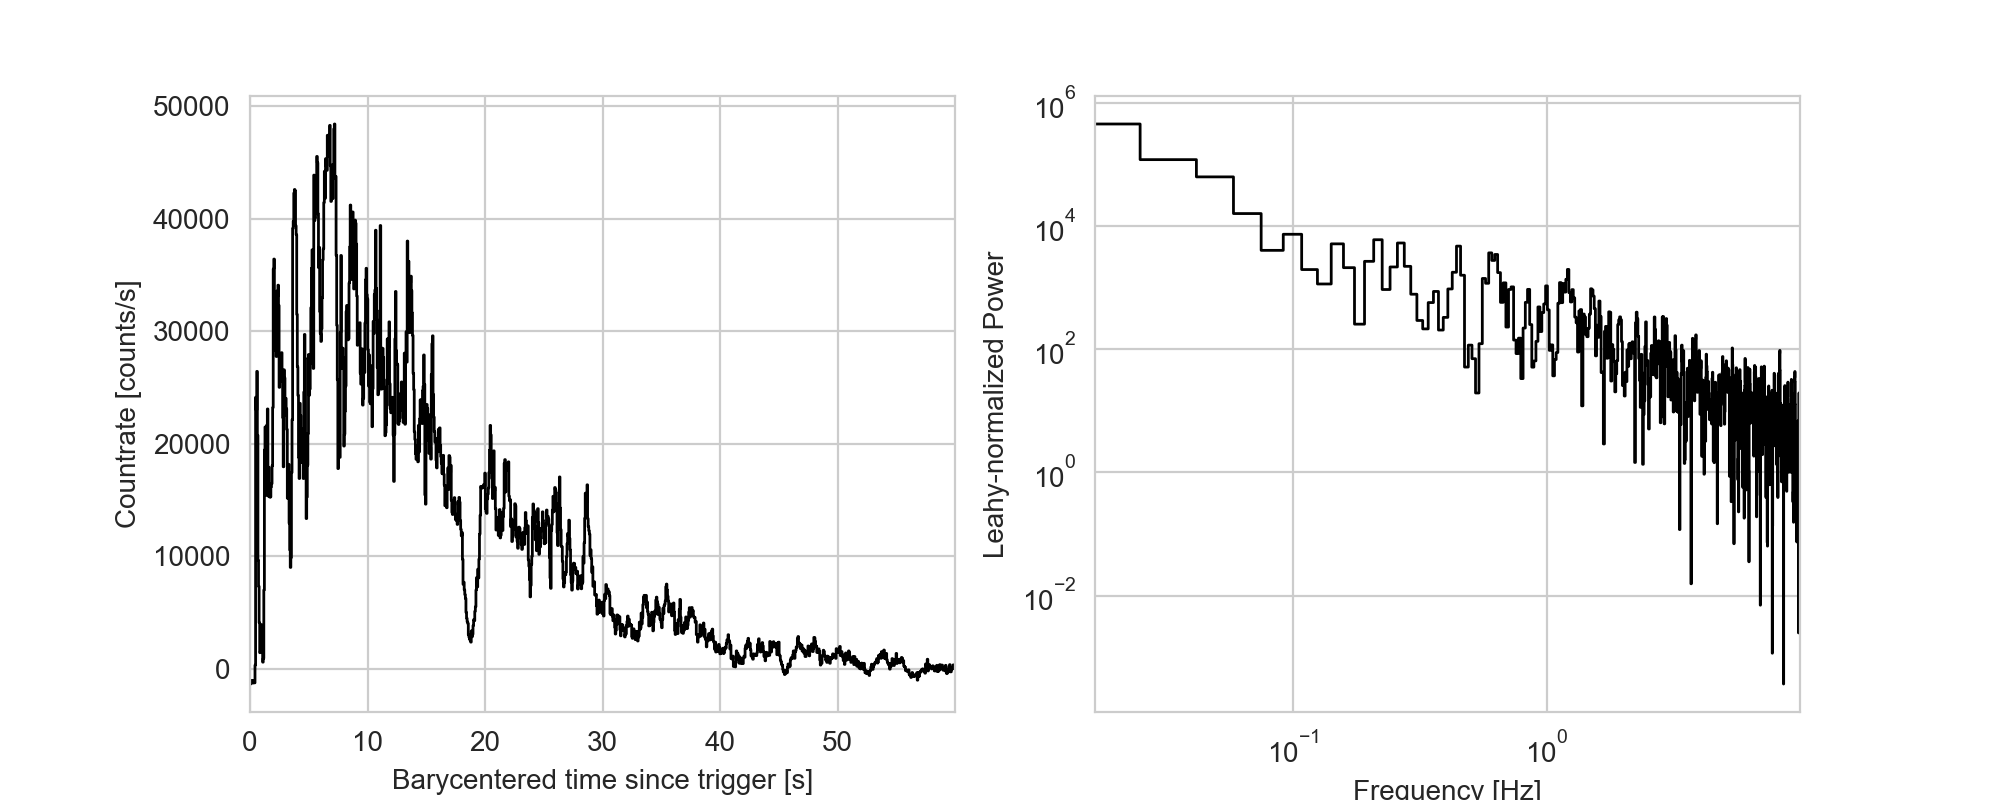

Text(0, 0.5, 'Leahy-normalized Power')

In [215]:
data = scipy.io.readsav(datadir+"bn230307656_na_mete.sav")
barytime = np.array(data["na_barytime"], dtype=float)
barytime = barytime
lc = Lightcurve.make_lightcurve(barytime, dt=0.05)

minind = lc.time.searchsorted(lc.tstart+24.5)
maxind = lc.time.searchsorted(lc.tstart + 84.5)
lc = lc.truncate(start=minind, stop=maxind, method="index")
mean_bkg = np.mean(lc.counts[-100:])

lc = Lightcurve(lc.time-lc.time[0], lc.counts-mean_bkg)
ps = Powerspectrum(lc, norm="leahy")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

ax1.plot(lc.time, lc.countrate, lw=1, color="black", ds="steps-mid")
ax1.set_xlim(lc.time[0], lc.time[-1])
ax1.set_xlabel("Barycentered time since trigger [s]")
ax1.set_ylabel("Countrate [counts/s]")

ax2.loglog(ps.freq, ps.power, ds="steps-mid", lw=1, color="black")
ax2.set_xlim(ps.freq[0], ps.freq[-1])
ax2.set_xlabel("Frequency [Hz]")
ax2.set_ylabel("Leahy-normalized Power")

In [216]:
with open(datadir+"fermi_na_drw_res.pkl", "rb") as f:
    res_rn = pickle.load(f)
with open(datadir+"fermi_nai_drw_qpo_res.pkl", "rb") as f:
    res_qporn = pickle.load(f)

In [217]:
samples_drw = resample_posterior(res_rn, random.PRNGKey(1342))
samples_qpo = resample_posterior(res_qporn, random.PRNGKey(1343))
#idx = 0 

kernel_type_drw = "RN"
kernel_type_qpo = "QPO_plus_RN"

mean_type = "skew_gaussian"

params_list_drw = get_gp_params(kernel_type= kernel_type_drw, mean_type = mean_type)
params_list_qpo = get_gp_params(kernel_type= kernel_type_qpo, mean_type = mean_type)

#pars_log_drw = dict((k, samples_drw[k][idx]) for k in params_list_drw)
#pars_log_qpo = dict((k, samples_qpo[k][idx]) for k in params_list_qpo)

pars_log_drw = get_max_posterior_parameters(res_rn)
pars_log_qpo = get_max_posterior_parameters(res_qporn)

pars_drw = {}
for params in params_list_drw:
    if params[0:4] == "log_":
        pars_drw[params[4:]] = jnp.exp(pars_log_drw[params])
    else:
        pars_drw[params] = pars_log_drw[params]

pars_qpo = {}
for params in params_list_qpo:
    if params[0:4] == "log_":
        pars_qpo[params[4:]] = jnp.exp(pars_log_qpo[params])
    else:
        pars_qpo[params] = pars_log_qpo[params]

mean_drw = get_mean(mean_type=mean_type, mean_params=pars_drw)
mean_qpo = get_mean(mean_type=mean_type, mean_params=pars_qpo)

kernel_drw = get_kernel(kernel_type=kernel_type_drw, kernel_params=pars_drw)
kernel_qpo = get_kernel(kernel_type=kernel_type_qpo, kernel_params=pars_qpo)

gp_drw = GaussianProcess(kernel_drw, lc.time, mean_value=mean_drw(lc.time), diag=np.sqrt(np.abs(lc.counts)))
gp_qpo = GaussianProcess(kernel_qpo, lc.time, mean_value=mean_qpo(lc.time), diag=np.sqrt(np.abs(lc.counts)))

_, cond_drw = gp_drw.condition(lc.counts, lc.time)
_, cond_qpo = gp_qpo.condition(lc.counts, lc.time)

tgrid = np.linspace(lc.time[0], lc.time[-1], 1)

tgrid = lc.time #np.hstack([lc.time, tgrid])
#tgrid = np.sort(tgrid)

_, cond_drw_big = gp_drw.condition(lc.counts, tgrid)
_, cond_qpo_big = gp_qpo.condition(lc.counts, tgrid)

mu_drw_big = cond_drw_big.loc + mean_drw(tgrid)
mu_qpo_big = cond_qpo_big.loc + mean_qpo(tgrid)

std_drw_big = np.sqrt(cond_drw_big.variance)
std_qpo_big = np.sqrt(cond_qpo_big.variance)


<IPython.core.display.Javascript object>


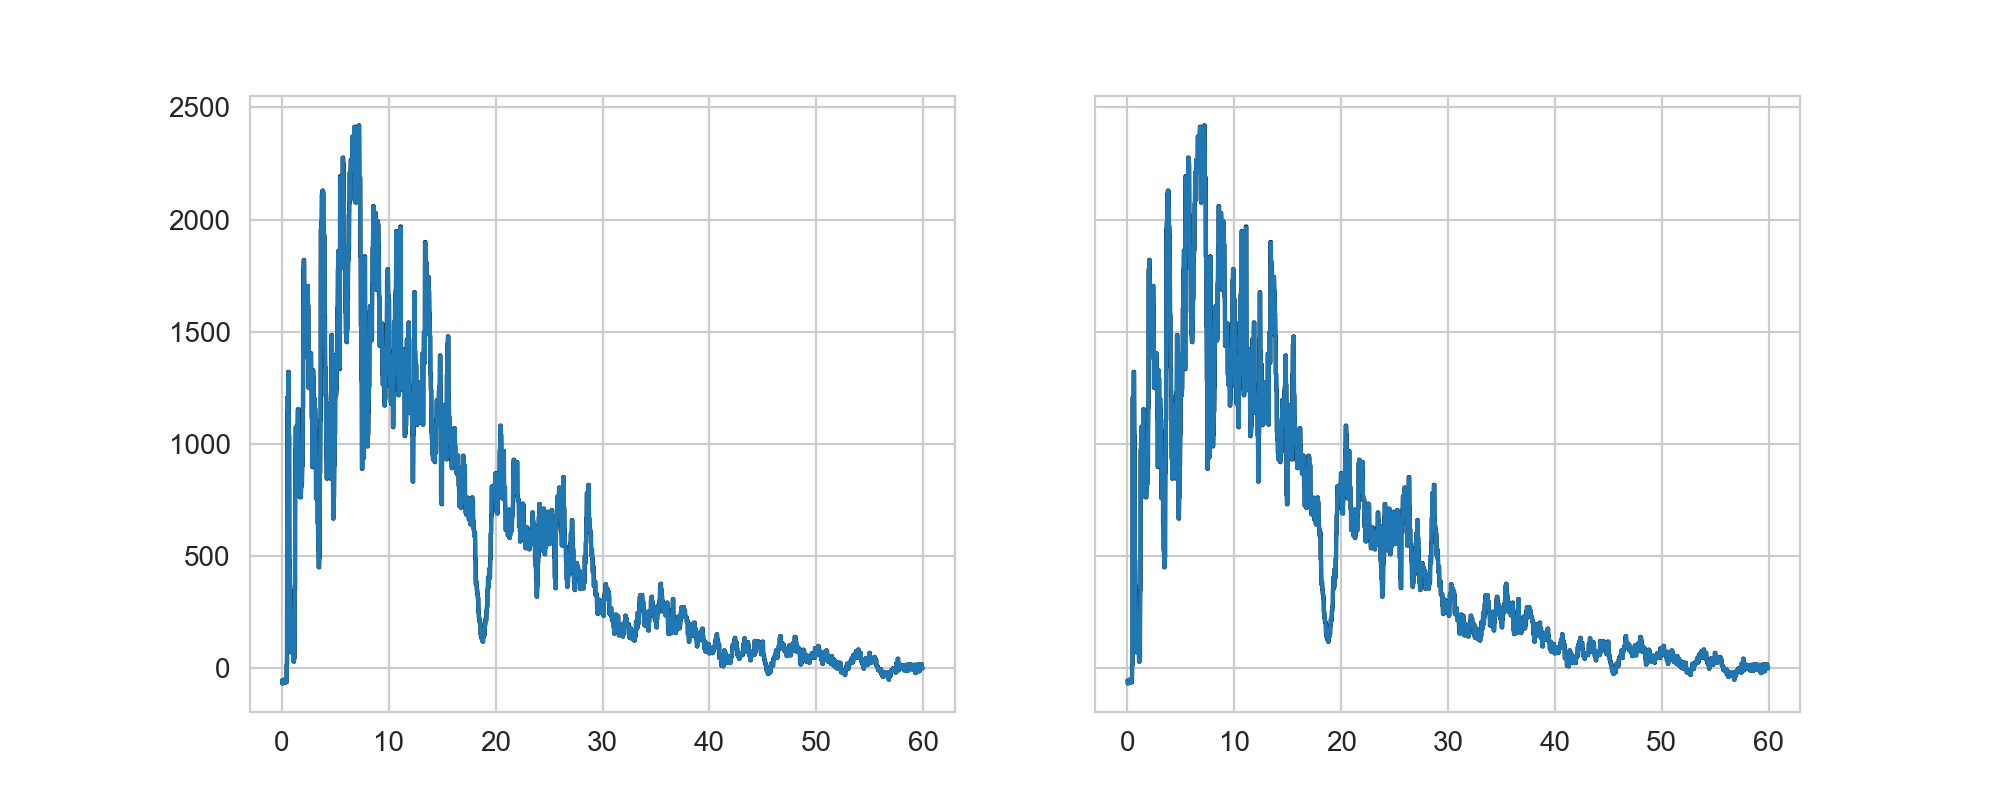

In [218]:
tgrid_idx = []

for t in lc.time:
    idx = tgrid.searchsorted(t)
    tgrid_idx.append(idx)
    
tgrid_idx = jnp.array(tgrid_idx)
mu_drw = mu_drw_big[tgrid_idx]
mu_qpo = mu_qpo_big[tgrid_idx]
std_drw = std_drw_big[tgrid_idx]
std_qpo = std_qpo_big[tgrid_idx]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4), sharex=True, sharey=True)

ax1.plot(lc.time, lc.counts, ds="steps-mid", color="black")
ax1.plot(tgrid, mu_drw_big, color=sns.color_palette()[0])
ax1.fill_between(tgrid, mu_drw_big + std_drw_big, mu_drw_big - std_drw_big, color=sns.color_palette()[0], alpha=0.3)


ax2.plot(lc.time, lc.counts, ds="steps-mid", color="black")
ax2.plot(tgrid, mu_qpo_big, color=sns.color_palette()[0])
ax2.fill_between(tgrid, mu_qpo_big + std_qpo_big, mu_qpo_big - std_qpo_big, color=sns.color_palette()[0], alpha=0.3)


In [219]:
mse_drw = np.sum((lc.counts - mu_drw)**2./np.sqrt(np.abs(lc.counts)))
mse_qpo = np.sum((lc.counts - mu_qpo)**2./np.sqrt(np.abs(lc.counts)))
print(f"MSE for DRW: {mse_drw}")
print(f"MSE for QPO+DRW: {mse_qpo}")
print(f"FUV DRW: {1.0 - np.sum((lc.counts - mu_drw)**2.)/np.var(lc.counts)}")
print(f"FUV QPO+DRW: {1. - np.sum((lc.counts - mu_qpo)**2.)/np.var(lc.counts)}")

MSE for DRW: 5.193766236814017
MSE for QPO+DRW: 5.439025701053031
FUV DRW: 0.9994470178897019
FUV QPO+DRW: 0.9994213100050282


In [220]:
cv_rn = kfold_cv(pars_log_drw, "RN", lc)
cv_qpo = kfold_cv(pars_log_qpo, "QPO_plus_RN", lc)
print(np.mean(cv_rn["r2"]))
print(np.mean(cv_qpo["r2"]))

0.019450021371420715
0.019464627136321286


In [221]:
fuv_drw = 1.0 - np.mean(r2_drw_all)
fuv_qpo = 1.0 - np.mean(r2_qpo_all)
print(f"FUV, DRW = {fuv_drw} +/- {np.std(r2_drw_all)}")
print(f"FUV, DRW+QPO = {fuv_qpo} +/- {np.std(r2_qpo_all)}")

FUV, DRW = 0.9767156852839759 +/- 0.006358480569837953
FUV, DRW+QPO = 0.9718977767664381 +/- 0.007467182783991353


In [223]:
nsamples = np.min([len(samples_drw[list(samples_drw.keys())[0]]),
                   len(samples_drw[list(samples_qpo.keys())[0]])])
nsim = 200

idx_all = np.random.choice(np.arange(0, nsamples, 1, dtype=int), size=nsim, replace=False)
nfolds = 5

kernel_type_drw = "RN"
kernel_type_qpo = "QPO_plus_RN"

mean_type = "skew_gaussian"

params_list_drw = get_gp_params(kernel_type= kernel_type_drw, mean_type = mean_type)
params_list_qpo = get_gp_params(kernel_type= kernel_type_qpo, mean_type = mean_type)

cv_rn_all = []
cv_qpo_all = []

r2_rn_all = []
r2_qpo_all = []

for i, idx in enumerate(idx_all):
    print(i)
    pars_log_drw = dict((k, samples_drw[k][idx]) for k in params_list_drw)
    pars_log_qpo = dict((k, samples_qpo[k][idx]) for k in params_list_qpo)

    cv_rn = kfold_cv(pars_log_drw, "RN", lc, folds=nfolds)
    cv_qpo = kfold_cv(pars_log_qpo, "QPO_plus_RN", lc, folds=nfolds)
    
    cv_rn_all.append(cv_rn)
    cv_qpo_all.append(cv_qpo)
    
    r2_rn_all.append(cv_rn["r2"])
    r2_qpo_all.append(cv_qpo["r2"])



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


In [224]:
r2_rn_all = np.array(r2_rn_all)
r2_qpo_all = np.array(r2_qpo_all)

In [225]:
np.savetxt(f"{datadir}fermi_nai_drw_r2_rn.dat", r2_rn_all)
np.savetxt(f"{datadir}fermi_nai_drw_r2_qpo.dat", r2_qpo_all)

In [226]:
r2_rn_all = np.loadtxt(f"{datadir}fermi_nai_drw_r2_rn.dat")
r2_qpo_all = np.loadtxt(f"{datadir}fermi_nai_drw_r2_qpo.dat")

In [227]:
sns.set_style("white")

In [232]:
np.mean(r2_rn_all)

0.02153366078821918

In [233]:
np.mean(r2_qpo_all)

0.021469308519005303

<IPython.core.display.Javascript object>


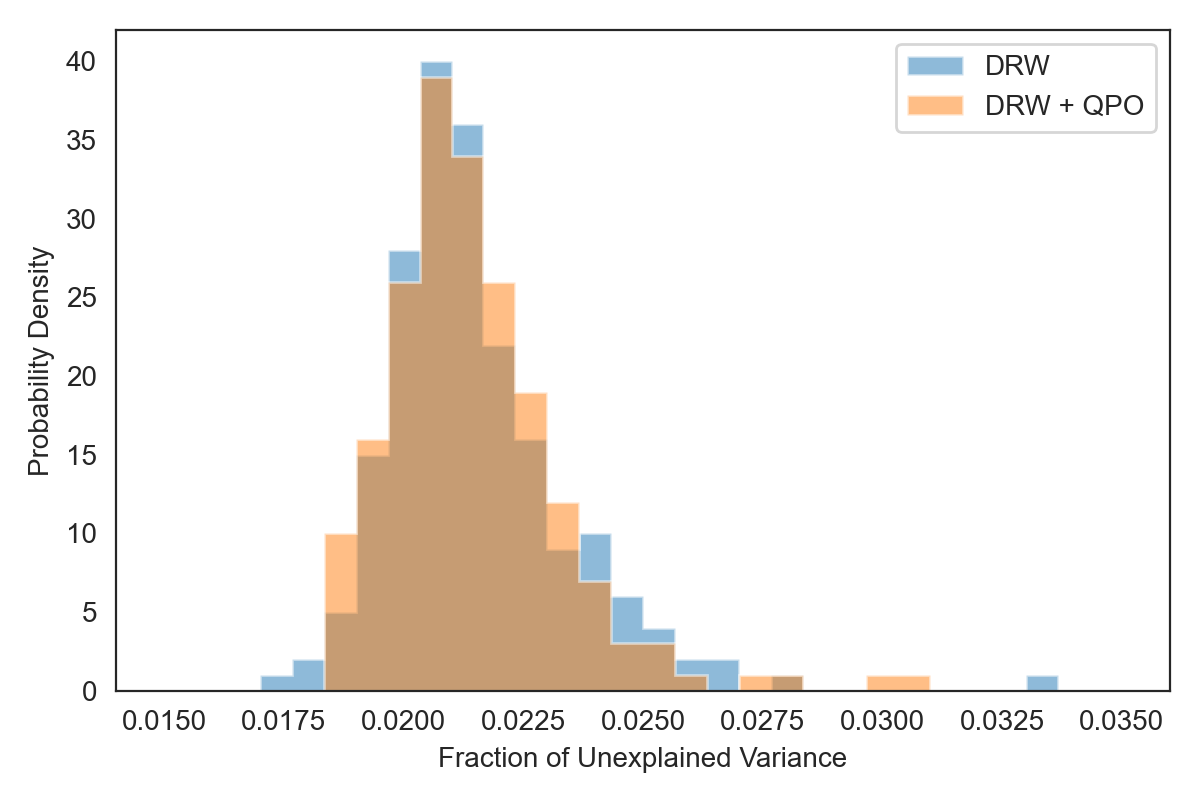

In [231]:
#histrange = [np.min(np.hstack([r2_rn_all,r2_qpo_all])),
#             np.max(np.hstack([r2_rn_all, r2_qpo_all]))]

histrange = [0.015, 0.035]

fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.hist(np.mean(r2_rn_all, axis=1), bins=30, histtype="stepfilled", 
        alpha=0.5, label="DRW", range=histrange)
ax.hist(np.mean(r2_qpo_all, axis=1), bins=30, histtype="stepfilled", 
        alpha=0.5, label="DRW + QPO", range=histrange);

#ax.set_xlim(0.015, 0.025)
ax.legend()

ax.legend()
ax.set_xlabel("Fraction of Unexplained Variance")
ax.set_ylabel("Probability Density")

fig.tight_layout()
figdir = "/Users/daniela/work/repositories/GRB230307A_QPOSearch/figures/"
fig.savefig(f"{figdir}fermi_nai_fuv.pdf", format="pdf")

## Fermi/GBM: BGO Detector Goodness of Fit

INFO[2023-10-27 10:33:25,611]: make_lightcurve: tseg: 144.99639451503754
INFO[2023-10-27 10:33:25,613]: make_lightcurve: timebin:  2899
INFO[2023-10-27 10:33:25,704]: Checking if light curve is well behaved. This can take time, so if you are sure it is already sorted, specify skip_checks=True at light curve creation.
INFO[2023-10-27 10:33:25,707]: Checking if light curve is sorted.
INFO[2023-10-27 10:33:25,710]: Computing the bin time ``dt``. This can take time. If you know the bin time, please specify it at light curve creation


<IPython.core.display.Javascript object>


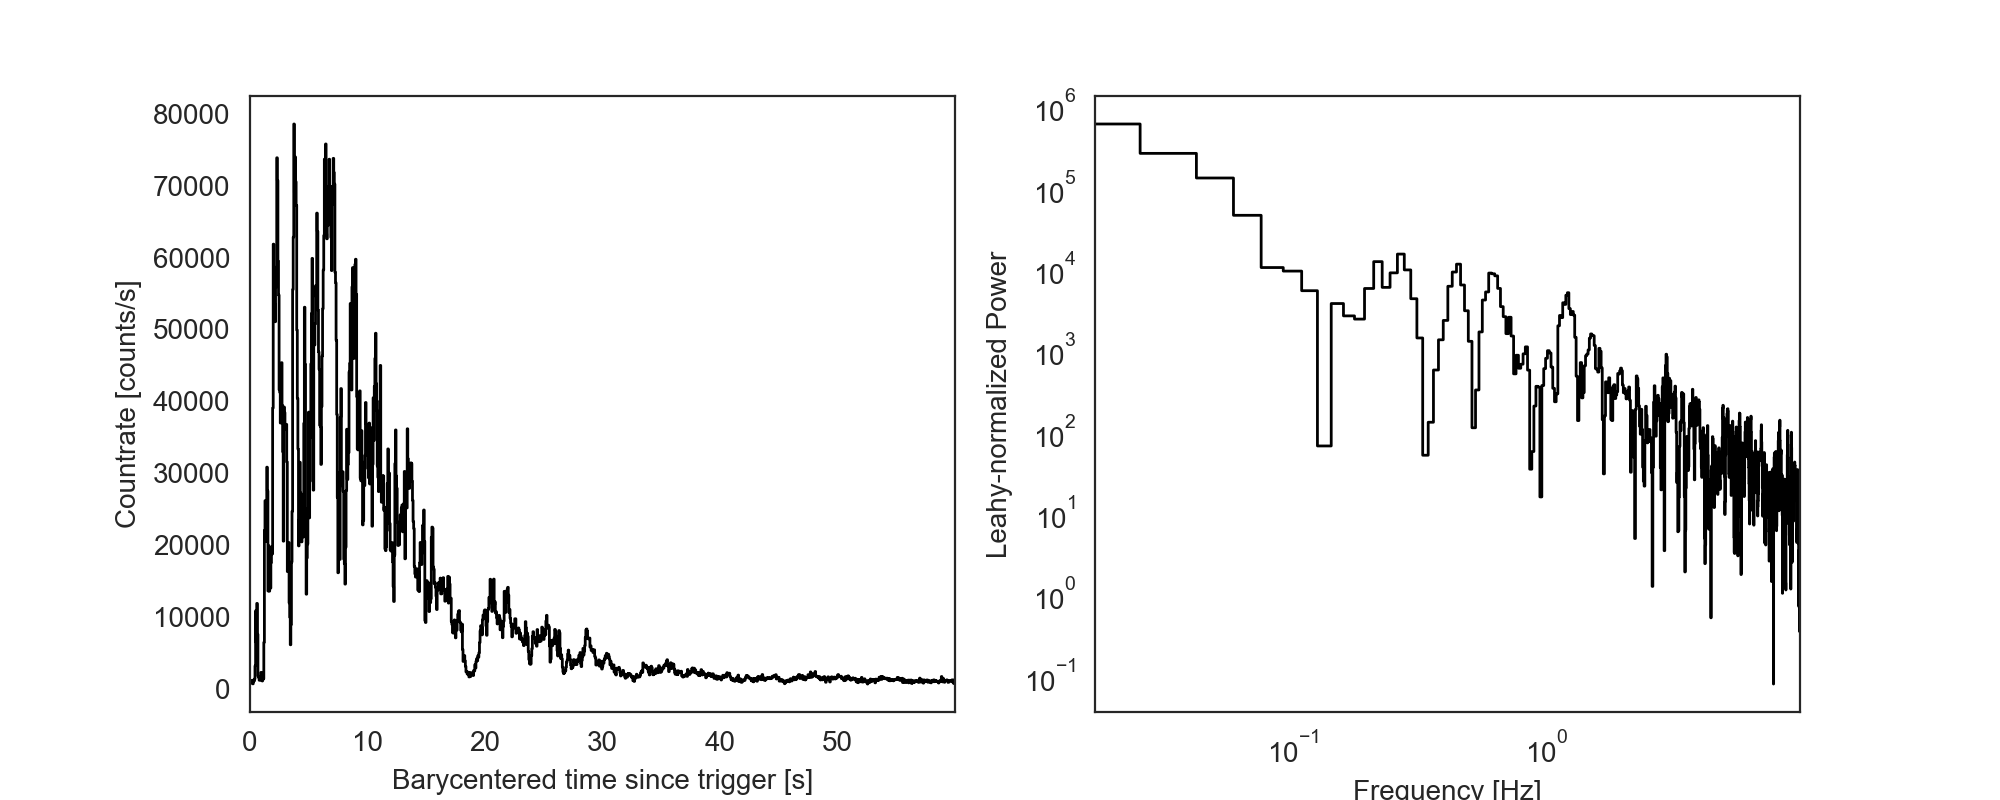

Text(0, 0.5, 'Leahy-normalized Power')

In [234]:
data = scipy.io.readsav(datadir+"bn230307656_b1_mete.sav")
barytime = np.array(data["b1_barytime"], dtype=float)

lc = Lightcurve.make_lightcurve(barytime, dt=0.05)

mean_bkg = np.mean(lc.counts[-100:])
minind = lc.time.searchsorted(lc.tstart+24.5)
maxind = lc.time.searchsorted(lc.tstart + 84.5)
lc = lc.truncate(start=minind, stop=maxind, method="index")
lc = Lightcurve(lc.time-lc.time[0], lc.counts)
ps = Powerspectrum(lc, norm="leahy")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

ax1.plot(lc.time, lc.countrate, lw=1, color="black", ds="steps-mid")
ax1.set_xlim(lc.time[0], lc.time[-1])
ax1.set_xlabel("Barycentered time since trigger [s]")
ax1.set_ylabel("Countrate [counts/s]")

ax2.loglog(ps.freq, ps.power, ds="steps-mid", lw=1, color="black")
ax2.set_xlim(ps.freq[0], ps.freq[-1])
ax2.set_xlabel("Frequency [Hz]")
ax2.set_ylabel("Leahy-normalized Power")

In [235]:
with open(datadir+"fermi_bgo_drw_res.pkl", "rb") as f:
    res_rn = pickle.load(f)
with open(datadir+"fermi_bgo_drw_qpo_res.pkl", "rb") as f:
    res_qporn = pickle.load(f)

In [236]:
samples_drw = resample_posterior(res_rn, random.PRNGKey(1445))
samples_qpo = resample_posterior(res_qporn, random.PRNGKey(1446))
#idx = 0 

kernel_type_drw = "RN"
kernel_type_qpo = "QPO_plus_RN"

mean_type = "skew_gaussian"

params_list_drw = get_gp_params(kernel_type= kernel_type_drw, mean_type = mean_type)
params_list_qpo = get_gp_params(kernel_type= kernel_type_qpo, mean_type = mean_type)

#pars_log_drw = dict((k, samples_drw[k][idx]) for k in params_list_drw)
#pars_log_qpo = dict((k, samples_qpo[k][idx]) for k in params_list_qpo)

pars_log_drw = get_max_posterior_parameters(res_rn)
pars_log_qpo = get_max_posterior_parameters(res_qporn)

pars_drw = {}
for params in params_list_drw:
    if params[0:4] == "log_":
        pars_drw[params[4:]] = jnp.exp(pars_log_drw[params])
    else:
        pars_drw[params] = pars_log_drw[params]

pars_qpo = {}
for params in params_list_qpo:
    if params[0:4] == "log_":
        pars_qpo[params[4:]] = jnp.exp(pars_log_qpo[params])
    else:
        pars_qpo[params] = pars_log_qpo[params]

mean_drw = get_mean(mean_type=mean_type, mean_params=pars_drw)
mean_qpo = get_mean(mean_type=mean_type, mean_params=pars_qpo)

kernel_drw = get_kernel(kernel_type=kernel_type_drw, kernel_params=pars_drw)
kernel_qpo = get_kernel(kernel_type=kernel_type_qpo, kernel_params=pars_qpo)

gp_drw = GaussianProcess(kernel_drw, lc.time, mean_value=mean_drw(lc.time), diag=np.sqrt(np.abs(lc.counts)))
gp_qpo = GaussianProcess(kernel_qpo, lc.time, mean_value=mean_qpo(lc.time), diag=np.sqrt(np.abs(lc.counts)))

_, cond_drw = gp_drw.condition(lc.counts, lc.time)
_, cond_qpo = gp_qpo.condition(lc.counts, lc.time)

tgrid = np.linspace(lc.time[0], lc.time[-1], 1)

tgrid = lc.time #np.hstack([lc.time, tgrid])
#tgrid = np.sort(tgrid)

_, cond_drw_big = gp_drw.condition(lc.counts, tgrid)
_, cond_qpo_big = gp_qpo.condition(lc.counts, tgrid)

mu_drw_big = cond_drw_big.loc + mean_drw(tgrid)
mu_qpo_big = cond_qpo_big.loc + mean_qpo(tgrid)

std_drw_big = np.sqrt(cond_drw_big.variance)
std_qpo_big = np.sqrt(cond_qpo_big.variance)


<IPython.core.display.Javascript object>


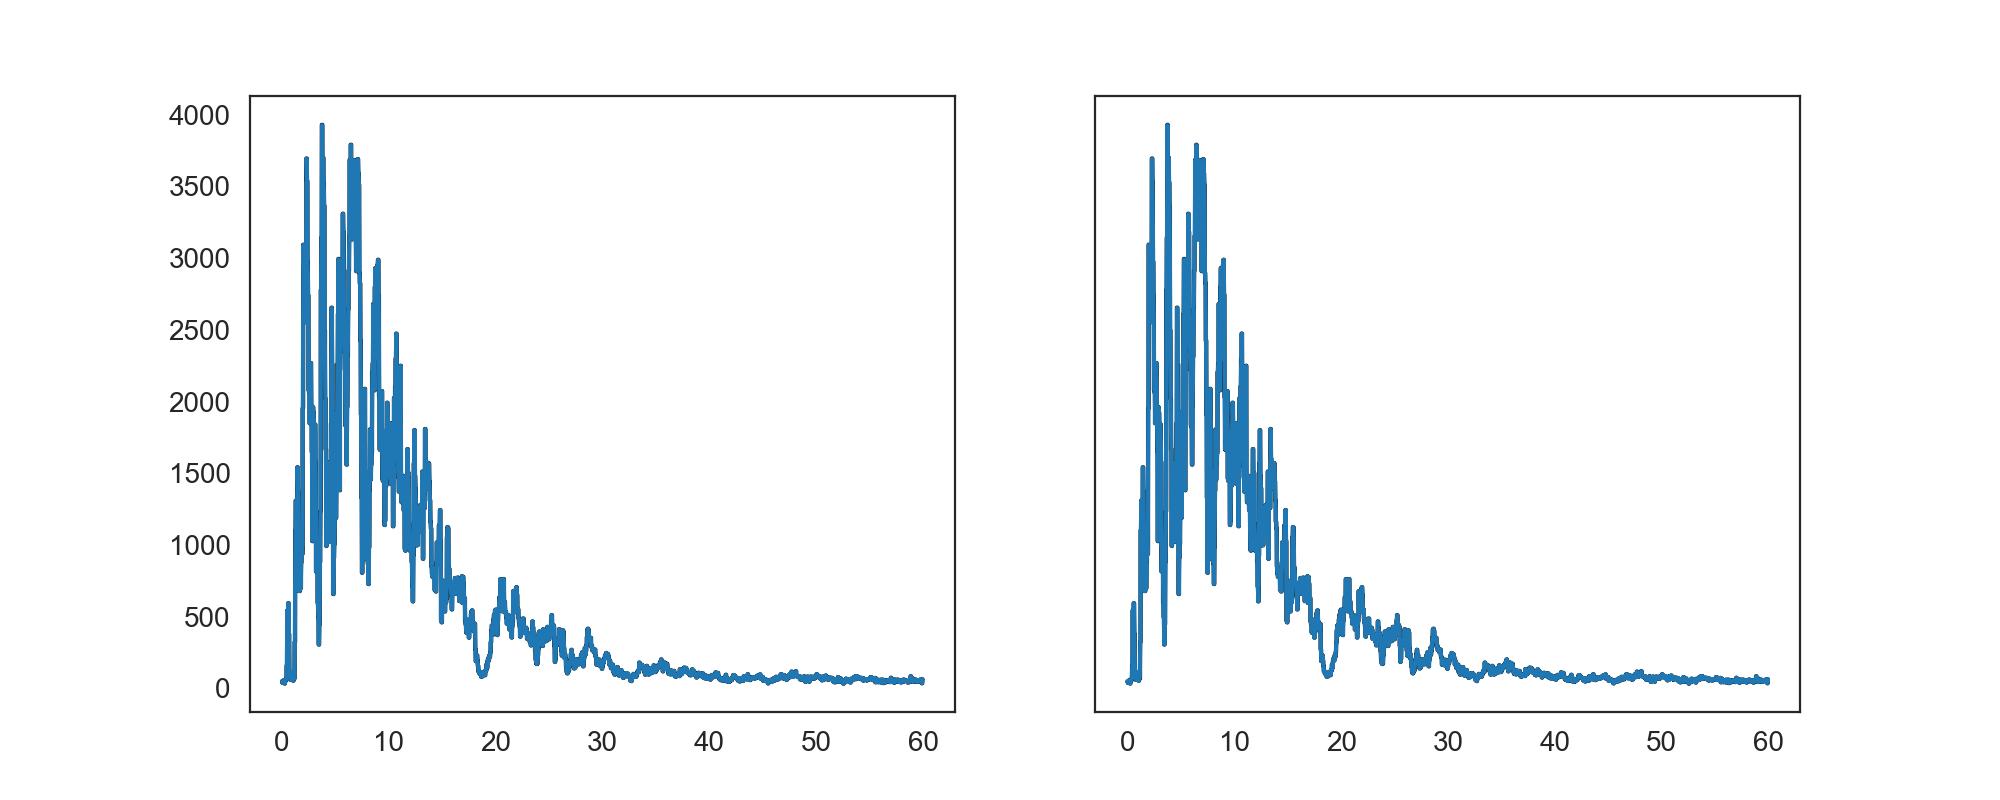

In [237]:
tgrid_idx = []

for t in lc.time:
    idx = tgrid.searchsorted(t)
    tgrid_idx.append(idx)
    
tgrid_idx = jnp.array(tgrid_idx)
mu_drw = mu_drw_big[tgrid_idx]
mu_qpo = mu_qpo_big[tgrid_idx]
std_drw = std_drw_big[tgrid_idx]
std_qpo = std_qpo_big[tgrid_idx]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4), sharex=True, sharey=True)

ax1.plot(lc.time, lc.counts, ds="steps-mid", color="black")
ax1.plot(tgrid, mu_drw_big, color=sns.color_palette()[0])
ax1.fill_between(tgrid, mu_drw_big + std_drw_big, mu_drw_big - std_drw_big, color=sns.color_palette()[0], alpha=0.3)


ax2.plot(lc.time, lc.counts, ds="steps-mid", color="black")
ax2.plot(tgrid, mu_qpo_big, color=sns.color_palette()[0])
ax2.fill_between(tgrid, mu_qpo_big + std_qpo_big, mu_qpo_big - std_qpo_big, color=sns.color_palette()[0], alpha=0.3)


In [238]:
mse_drw = np.sum((lc.counts - mu_drw)**2./np.sqrt(np.abs(lc.counts)))
mse_qpo = np.sum((lc.counts - mu_qpo)**2./np.sqrt(np.abs(lc.counts)))
print(f"MSE for DRW: {mse_drw}")
print(f"MSE for QPO+DRW: {mse_qpo}")
print(f"FUV DRW: {1.0 - np.sum((lc.counts - mu_drw)**2.)/np.var(lc.counts)}")
print(f"FUV QPO+DRW: {1. - np.sum((lc.counts - mu_qpo)**2.)/np.var(lc.counts)}")

MSE for DRW: 2.4151812873457428
MSE for QPO+DRW: 2.6448016344798666
FUV DRW: 0.999825738723876
FUV QPO+DRW: 0.9998095644192543


In [239]:
cv_rn = kfold_cv(pars_log_drw, "RN", lc)
cv_qpo = kfold_cv(pars_log_qpo, "QPO_plus_RN", lc)
print(np.mean(cv_rn["r2"]))
print(np.mean(cv_qpo["r2"]))

0.02870267954637585
0.026049746987100948


In [240]:
fuv_drw = 1.0 - np.mean(r2_drw_all)
fuv_qpo = 1.0 - np.mean(r2_qpo_all)
print(f"FUV, DRW = {fuv_drw} +/- {np.std(r2_drw_all)}")
print(f"FUV, DRW+QPO = {fuv_qpo} +/- {np.std(r2_qpo_all)}")

FUV, DRW = 0.9767156852839759 +/- 0.006358480569837953
FUV, DRW+QPO = 0.9785306914809947 +/- 0.005892375911538669


In [241]:
nsamples = np.min([len(samples_drw[list(samples_drw.keys())[0]]),
                   len(samples_drw[list(samples_qpo.keys())[0]])])
nsim = 200
nfolds = 5

idx_all = np.random.choice(np.arange(0, nsamples, 1, dtype=int), size=nsim, replace=False)
#idx = 0 

kernel_type_drw = "RN"
kernel_type_qpo = "QPO_plus_RN"

mean_type = "skew_gaussian"

params_list_drw = get_gp_params(kernel_type= kernel_type_drw, mean_type = mean_type)
params_list_qpo = get_gp_params(kernel_type= kernel_type_qpo, mean_type = mean_type)

cv_rn_all = []
cv_qpo_all = []

r2_rn_all = []
r2_qpo_all = []

for idx in idx_all:
    pars_log_drw = dict((k, samples_drw[k][idx]) for k in params_list_drw)
    pars_log_qpo = dict((k, samples_qpo[k][idx]) for k in params_list_qpo)

    cv_rn = kfold_cv(pars_log_drw, "RN", lc, folds=nfolds)
    cv_qpo = kfold_cv(pars_log_qpo, "QPO_plus_RN", lc, folds=nfolds)
    
    cv_rn_all.append(cv_rn)
    cv_qpo_all.append(cv_qpo)
    
    r2_rn_all.append(cv_rn["r2"])
    r2_qpo_all.append(cv_qpo["r2"])



In [153]:
r2_rn_all = np.array(r2_rn_all)
r2_qpo_all = np.array(r2_qpo_all)

In [154]:
np.savetxt(f"{datadir}fermi_bgo_drw_r2_rn.dat", r2_rn_all)
np.savetxt(f"{datadir}fermi_bgo_drw_r2_qpo.dat", r2_qpo_all)

In [155]:
sns.set_style("white")

In [156]:
np.mean(r2_rn_all)

0.028360281780630457

In [157]:
np.mean(r2_qpo_all)

0.028517398758519726

<IPython.core.display.Javascript object>


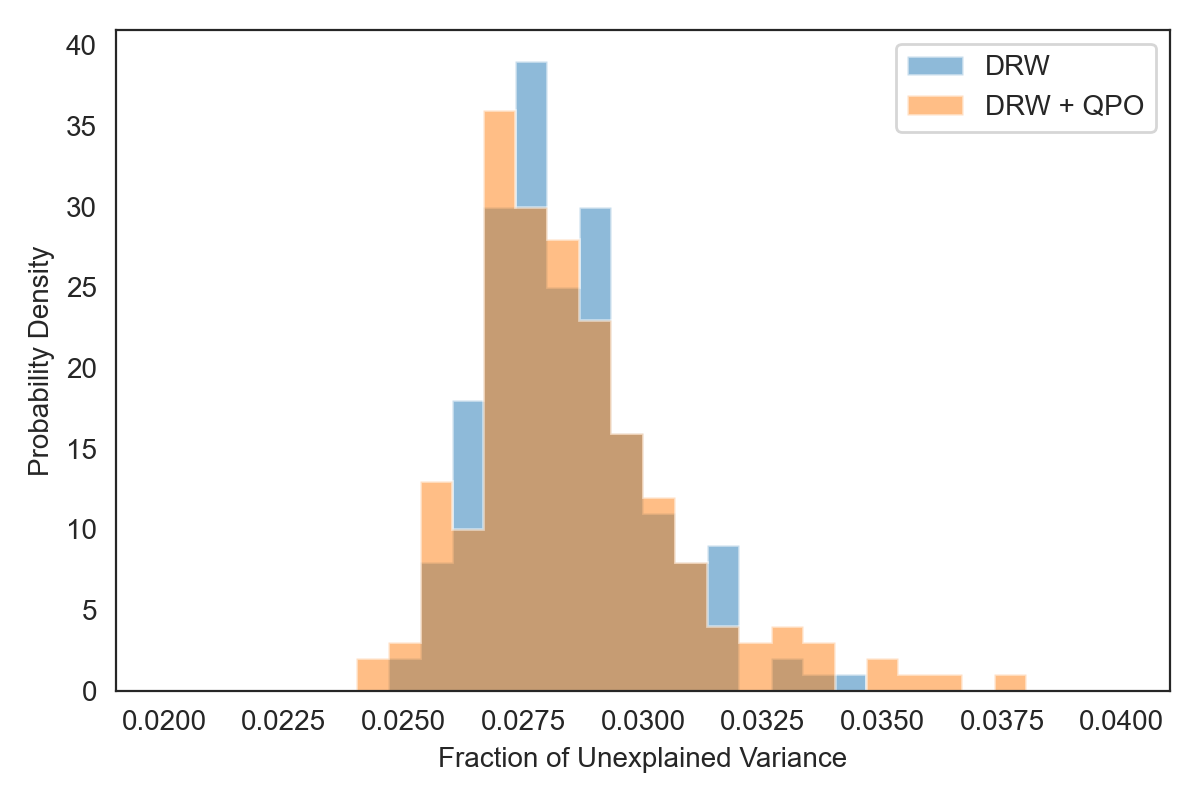

In [162]:
histrange = [np.min(np.hstack([r2_rn_all,r2_qpo_all])),
             np.max(np.hstack([r2_rn_all, r2_qpo_all]))]

histrange = [0.02, 0.04]

fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.hist(np.mean(r2_rn_all, axis=1), bins=30, histtype="stepfilled", 
        alpha=0.5, label="DRW", range=histrange)
ax.hist(np.mean(r2_qpo_all, axis=1), bins=30, histtype="stepfilled", 
        alpha=0.5, label="DRW + QPO", range=histrange);

#ax.set_xlim(0.015, 0.025)
ax.legend()

ax.legend()
ax.set_xlabel("Fraction of Unexplained Variance")
ax.set_ylabel("Probability Density")

fig.tight_layout()
figdir = "/Users/daniela/work/repositories/GRB230307A_QPOSearch/figures/"
fig.savefig(f"{figdir}fermi_bgo_fuv.pdf", format="pdf")